In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class BranchGenParticles:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Particle.Status"].array())
        self.Status = file["Particle.Status"].array()
        self.PID = file["Particle.PID"].array()
        self.M1 = file["Particle.M1"].array()
        self.M2 = file["Particle.M2"].array()
        self.D1 = file["Particle.D1"].array()
        self.D2  = file["Particle.D2"].array()
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        self.Charge = file["Particle.Charge"].array()
        self.Labels = ["Status", "PID" , "M1", "M2", "D1", "D2", "PT", "Eta", "Phi", "Mass","Charge"]
        
    def length_At(self, i):
        return len(self.Status[i])
    def Status_At(self, i):
        return self.Status[i]
    def PID_At(self, i):
        return self.PID[i]
    def M1_At(self, i):
        return self.M1[i]
    def M2_At(self, i):
        return self.M2[i]
    def D1_At(self, i):
        return self.D1[i]
    def D2_At(self, i):
        return self.D2[i]
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    def Charge_At(self, i):
        return self.Charge[i]
    
def digit(loc,pid):
    #     //  PID digits (base 10) are: n nr nl nq1 nq2 nq3 nj
    #     //   nj = 1, nq3=2 , nq2=3, nq1, nl, nr, n, n8, n9, n10 
    #     //  the location enum provides a convenient index into the PID
    numerator = 10**(loc-1)
    
    return int((abs(pid)/numerator)%10)

def hasBottom(pid):
    # get B hadron
    # PID for B hadron are 5XX, 5XXX
    # https://gitlab.com/hepcedar/rivet/-/blob/release-3-1-x/analyses/pluginCMS/CMS_2015_I1370682.cc#L390
    # https://rivet.hepforge.org/code/2.1.0/a00827.html#ad4c917595339ea52152c2950ce1225e7
    # https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    if( digit(2,pid) == 5 or digit(3,pid) == 5 or digit(4,pid) == 5 ):
        return True
    else:
        return False

In [3]:
def Get_bjet_PT_Eta_InvM(file_path, n_bjet=6, nevent_max=100000):
    
    root_file = uproot.open(file_path)["Delphes;1"]
    
    jet_PT = root_file["Jet.PT"].array()
    jet_Eta = root_file["Jet.Eta"].array()
    jet_Phi = root_file["Jet.Phi"].array()
    jet_Mass = root_file["Jet.Mass"].array()

    jet_BTag = root_file["Jet.BTag"].array()

    b_PT, b_Eta, b_M = [], [], []
    nevent = min(len(jet_PT), nevent_max)
    
    for event in tqdm(range(nevent)):
        BTag = jet_BTag[event]

        if np.sum(BTag)>=n_bjet:
            PT = jet_PT[event][BTag==1][0:n_bjet]
            Eta = jet_Eta[event][BTag==1][0:n_bjet]
            Phi = jet_Phi[event][BTag==1][0:n_bjet]
            Mass = jet_Mass[event][BTag==1][0:n_bjet]
            
            b_PT.append(PT)
            b_Eta.append(Eta)
            
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            total_inv_mass = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
            b_M.append(total_inv_mass)
    
    return b_PT, b_Eta, b_M


def PT_Eta_hist(b_PT, b_Eta, title=""):
    PT = np.array(b_PT)
    Eta = np.array(b_Eta)
    
    n = len(PT[0])

    fig, ax = plt.subplots(n, 2, figsize=(14, n*5))

    for i in range(len(ax)):
        ax[i,0].hist(PT[:,i], bins=50, range=[0,500])
        ax[i,0].set_xlabel("PT")
        ax[i,0].set_ylabel("Numbers")
        ax[i,0].set_title(title)

        ax[i,1].hist(Eta[:,i], bins=20,range=[-5,5])
        ax[i,1].set_xlabel("Eta")
        ax[i,1].set_ylabel("Numbers")
        ax[i,1].set_title(title)

    # plt.savefig(title + "_PT_Eta_order_by_PT.png")
    plt.show()
    
def InvM_hist(b_M, title=""):
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    
    ax.hist(b_M, bins=50)
    ax.set_xlabel("total invariant mass")
    ax.set_ylabel("Numbers")
    ax.set_title(title)
    
    plt.show() 

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    
    return e, px, py, pz
    
def InvM(e, px, py, pz):
    return np.sqrt(e**2 - px**2 - py**2 - pz**2)

In [4]:
def Cutflow_table_b_jet(file_path, title="", nevent_max=1000):

    root_file = uproot.open(file_path)["Delphes;1"]

    bTag_count = 0
    Eta_count = 0
    PT25_count = 0
    PT40_count = 0

    jet_PT = root_file["Jet.PT"].array()
    jet_Eta = root_file["Jet.Eta"].array()

    jet_BTag = root_file["Jet.BTag"].array()

    nevent = min(len(jet_PT), nevent_max)

    for event in tqdm(range(nevent)):
        BTag = jet_BTag[event]

        if np.sum(BTag)>=6:
            bTag_count += 1
            PT = jet_PT[event][BTag==1]
            Eta = jet_Eta[event][BTag==1]

            # |eta| < 2.5
            b_index_eta_cut = np.where(np.abs(Eta)<2.5)[0]

            if len(b_index_eta_cut)>=6 :
                Eta_count += 1

                if np.array(PT[b_index_eta_cut]>25).astype("int").sum()>=6:
                    PT25_count += 1

                    if np.array(PT[b_index_eta_cut]>40).astype("int").sum()>=4:
                        PT40_count += 1

    print(title)
    print("In", nevent, "events")
    print("more than 6 b-jets",bTag_count)
    print("|eta| < 2.5 for 6 b-jets:", Eta_count)
    print("PT > 25 GeV for 6 b-jets:", PT25_count)
    print("PT > 40 GeV for 4 b-jets:", PT40_count)

## Signal 

In [5]:
# 100k gg->h3->h2h->hhh b-tagging efficiency=1
file_path = "/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/gg_h3_h2h_hhh/Events/run_01/tag_1_delphes_events.root"
b_PT_h3, b_Eta_h3, b_M_h3 = Get_bjet_PT_Eta_InvM(file_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:20<00:00, 711.59it/s]


21659


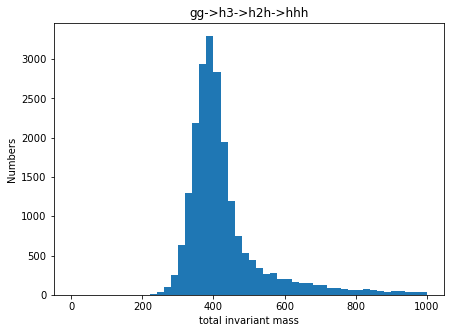

In [6]:
print(len(b_M_h3))
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(b_M_h3, bins=50, range = [0,1000])
ax.set_xlabel("total invariant mass")
ax.set_ylabel("Numbers")
ax.set_title("gg->h3->h2h->hhh")

plt.savefig("signal_resonant_6_b-jets_total_invariant_mass.png", facecolor="White")
plt.show() 

## Correct parameter: signal

In [7]:
# 100k gg->hhh b-tagging efficiency=1
file_path = "/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/gghhh_bsm/Events/run_06/tag_1_delphes_events.root"

b_PT_gghhh, b_Eta_gghhh, b_M_gghhh = Get_bjet_PT_Eta_InvM(file_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:17<00:00, 725.31it/s]


21814


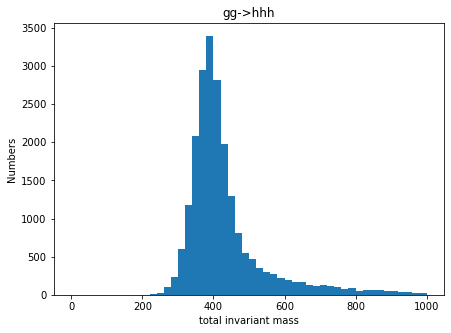

In [8]:
print(len(b_M_gghhh))
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(b_M_gghhh, bins=50, range = [0,1000])
ax.set_xlabel("total invariant mass")
ax.set_ylabel("Numbers")
ax.set_title("gg->hhh")

plt.savefig("signal_6_b-jets_total_invariant_mass_correct.png", facecolor="White")
plt.show() 

In [9]:
# 100k gg->h3->h2h->hhh b-tagging efficiency=1
file_path = "/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/gg_h3_h2h_hhh/Events/run_07/tag_1_delphes_events.root"
b_PT_res, b_Eta_res, b_M_res = Get_bjet_PT_Eta_InvM(file_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:17<00:00, 727.47it/s]


21475


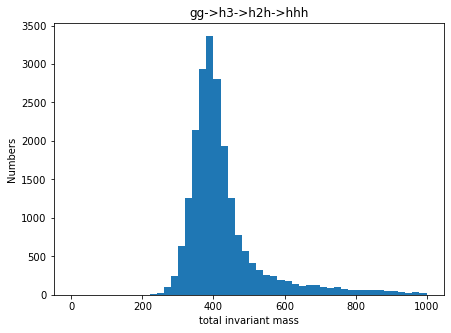

In [10]:
print(len(b_M_res))
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(b_M_res, bins=50, range = [0,1000])
ax.set_xlabel("total invariant mass")
ax.set_ylabel("Numbers")
ax.set_title("gg->h3->h2h->hhh")

plt.savefig("signal_resonant_6_b-jets_total_invariant_mass_correct.png", facecolor="White")
plt.show()

## gg->hhh v.s. gg->h3->h2h->hhh (resonant)

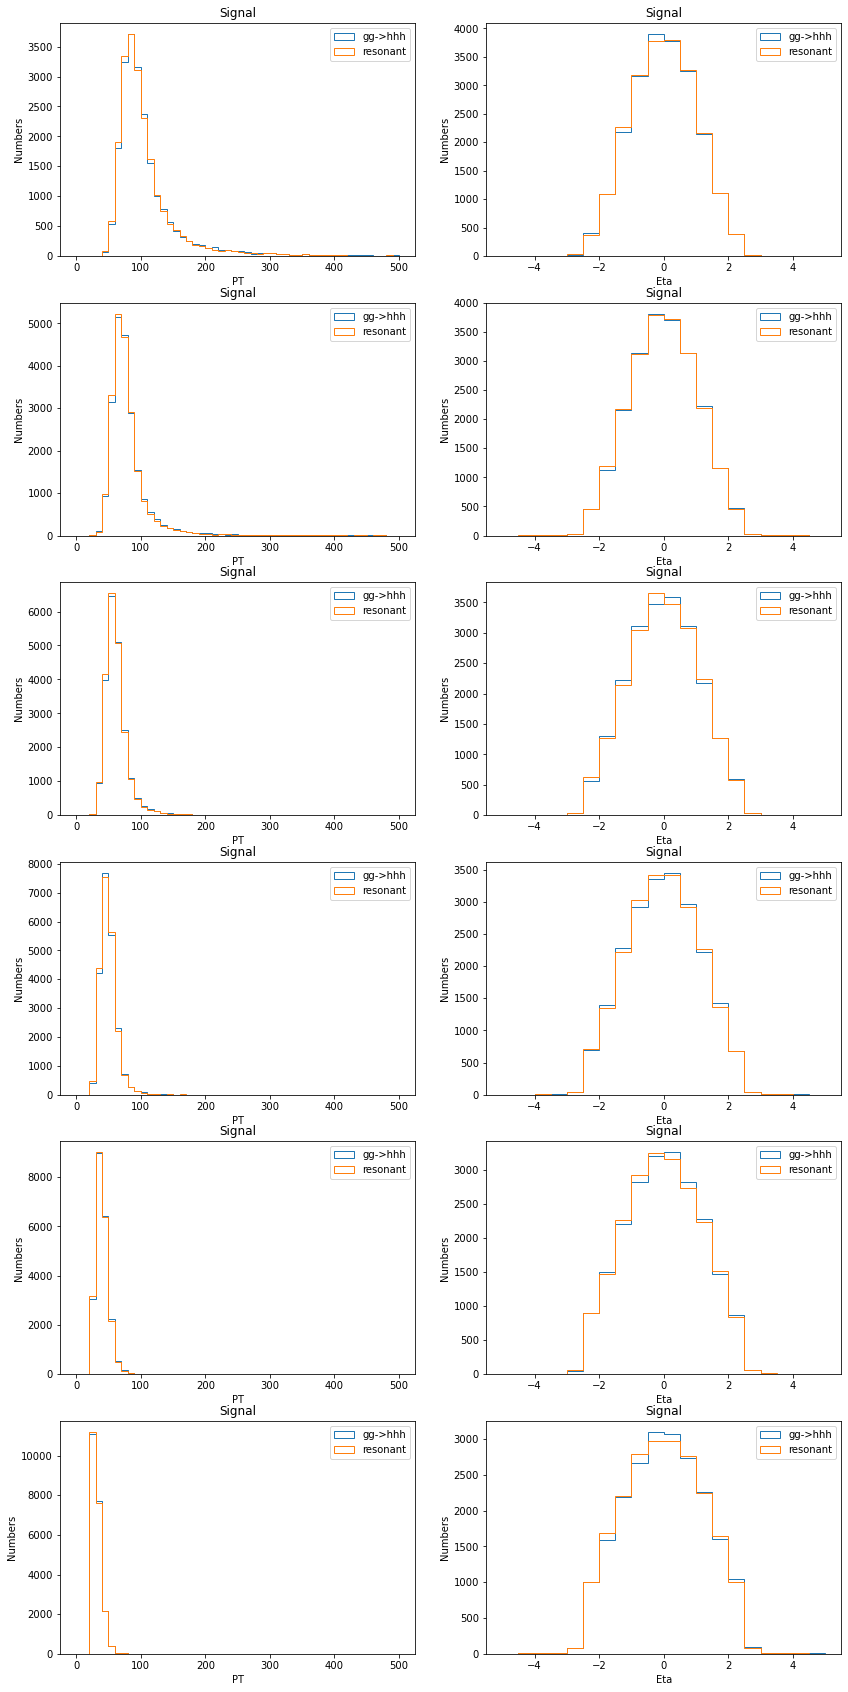

In [11]:
title = "Signal"
PT1 = np.array(b_PT_gghhh)
Eta1 = np.array(b_Eta_gghhh)

PT2 = np.array(b_PT_res)
Eta2 = np.array(b_Eta_res)

n = len(PT1[0])
factor = len(PT2)/len(PT1)

fig, ax = plt.subplots(n, 2, figsize=(14, n*5))

for i in range(len(ax)):
    ax[i,0].hist(PT1[:,i], bins=50, range=[0,500], histtype='step', weights=factor*np.ones_like(PT1[:,i]), label="gg->hhh")
    ax[i,0].set_xlabel("PT")
    ax[i,0].set_ylabel("Numbers")
    ax[i,0].set_title(title)

    ax[i,1].hist(Eta1[:,i], bins=20,range=[-5,5], histtype='step', weights=factor*np.ones_like(Eta1[:,i]), label="gg->hhh")
    ax[i,1].set_xlabel("Eta")
    ax[i,1].set_ylabel("Numbers")
    ax[i,1].set_title(title)
    
    ax[i,0].hist(PT2[:,i], bins=50, range=[0,500], histtype='step', label="resonant")
    ax[i,0].set_xlabel("PT")
    ax[i,0].set_ylabel("Numbers")
    ax[i,0].set_title(title)

    ax[i,1].hist(Eta2[:,i], bins=20,range=[-5,5], histtype='step', label="resonant")
    ax[i,1].set_xlabel("Eta")
    ax[i,1].set_ylabel("Numbers")
    ax[i,1].set_title(title)
    
    ax[i,0].legend()
    ax[i,1].legend()

plt.savefig(title + "_PT_Eta_order_by_PT.png", facecolor="White")

plt.show()

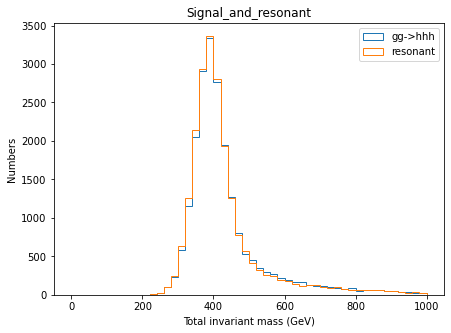

In [17]:
title = "Signal_and_resonant"

fig, ax = plt.subplots(1, 1, figsize=(7,5))
M1 = np.array(b_M_gghhh)
M2 = np.array(b_M_res)

factor = len(M2)/len(M1)

ax.hist(M1, bins=50, range=[0,1000], histtype='step', weights=factor*np.ones_like(M1), label="gg->hhh")
ax.hist(M2, bins=50, range=[0,1000], histtype='step', label="resonant")
ax.set_xlabel("Total invariant mass (GeV)")
ax.set_ylabel("Numbers")
ax.legend()
ax.set_title(title)

plt.savefig(title + "_total_invariant_mass.png", facecolor="White")
plt.show()

In [13]:
# 100k 14 TeV gg->hhh b-tagging efficiency=1
file_path = "/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/gghhh_bsm/Events/run_06/tag_1_delphes_events.root"
Cutflow_table_b_jet(file_path, title="signal", nevent_max=100000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:10<00:00, 1423.11it/s]

signal
In 100000 events
more than 6 b-jets 21814
|eta| < 2.5 for 6 b-jets: 21254
PT > 25 GeV for 6 b-jets: 17130
PT > 40 GeV for 4 b-jets: 14142


In [14]:
# 100k 14 TeV gg->h3->h2h->hhh b-tagging efficiency=1
file_path = "/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/gg_h3_h2h_hhh/Events/run_07/tag_1_delphes_events.root"
Cutflow_table_b_jet(file_path, title="signal", nevent_max=100000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:10<00:00, 1420.52it/s]

signal
In 100000 events
more than 6 b-jets 21475
|eta| < 2.5 for 6 b-jets: 20898
PT > 25 GeV for 6 b-jets: 16828
PT > 40 GeV for 4 b-jets: 13730
